# Evaluation of projection module

In [1]:
import pickle
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from focal_loss.focal_loss import FocalLoss
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os
from utils import *
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Filepath to embeddings
fname = "/mnt/mimic/data/HAIM/mimic_extras/embeddings.csv"

# YES-TOKEN: 3276
# NO-TOKEN: 956

### Load data and make predictions

In [10]:
model = torch.load('results/bce_vd/finetuned.pth').to('cuda')
model.eval()

ProjectionNN(
  (bn1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1024, out_features=1024, bias=True)
  (relu1): ReLU()
  (drop1): Dropout(p=0.15, inplace=False)
  (fc4): Linear(in_features=1024, out_features=512, bias=True)
  (ln4): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (relu4): ReLU()
  (fc5): Linear(in_features=512, out_features=2, bias=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
)

In [3]:
df = pd.read_csv(fname)

Data = DataSplit(df)
Data.split_data('mortality')

X,V,T = Data.get_type('vd_')

x_test = T.values.tolist()
labels = Data.y_test.tolist()

/home/oskar/gemma/multimodal_healthcare/utils.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_death_small48['y'] = 1
/home/oskar/gemma/multimodal_healthcare/utils.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alive_big48['y'] = 0
/home/oskar/gemma/multimodal_healthcare/utils.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

In [ ]:
np.random.seed(42)
x_test = select_random_subset(x_test)
labels = select_random_subset(labels)

In [11]:
preds = []

for i, item in enumerate(x_test):
    inputs = torch.tensor(item, dtype=torch.float32).unsqueeze(0).to('cuda')
    output = model.forward(inputs)
    hard_pred = torch.argmax(output, dim=1)
    preds.append(hard_pred)

### Training losses

In [12]:
folder = 'results/bce_vd'

with open(f"{folder}/train_losses.pkl", "rb") as input_file:
    train_losses = pickle.load(input_file)

with open(f"{folder}/train_accs.pkl", "rb") as input_file:
    train_accs = pickle.load(input_file)

with open(f"{folder}/val_losses.pkl", "rb") as input_file:
    val_losses = pickle.load(input_file)

with open(f"{folder}/val_accs.pkl", "rb") as input_file:
    val_accs = pickle.load(input_file)

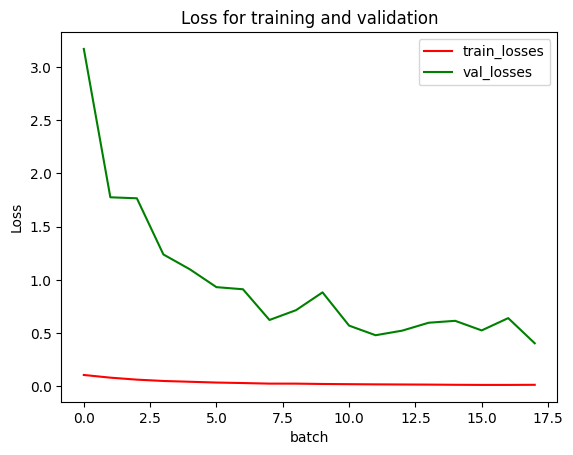

In [13]:
x = list(range(len(train_losses)))

repetitions = len(train_losses) // len(val_losses)
extended_val_loss = [element for element in val_losses for _ in range(repetitions)]

remaining_elements = len(train_losses) % len(val_losses)
if remaining_elements > 0:
    extended_val_loss += val_losses[:remaining_elements]

plt.plot(x, train_losses, color='r', label='train_losses')
plt.plot(x, extended_val_loss, color='g', label='val_losses')

plt.title('Loss for training and validation')
plt.ylabel('Loss')
plt.xlabel('batch')

plt.legend()


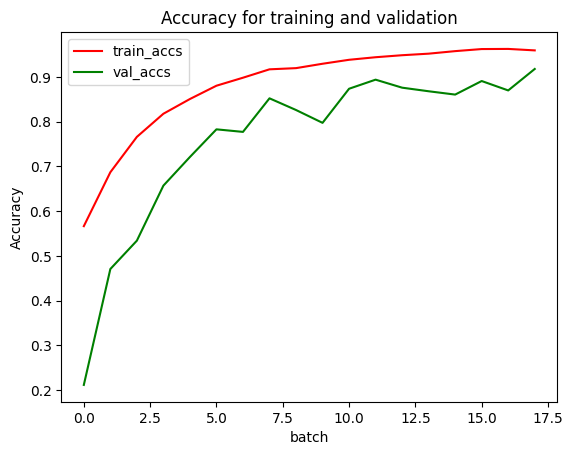

In [14]:
x = list(range(len(train_accs)))

repetitions = len(train_accs) // len(val_accs)
extended_val_accs = [element for element in val_accs for _ in range(repetitions)]

remaining_elements = len(train_accs) % len(val_accs)
if remaining_elements > 0:
    extended_val_accs += val_accs[:remaining_elements]

plt.plot(x, train_accs, color='r', label='train_accs')
plt.plot(x, extended_val_accs, color='g', label='val_accs')

plt.title('Accuracy for training and validation')
plt.ylabel('Accuracy')
plt.xlabel('batch')

plt.legend()

### Confusion Matrix

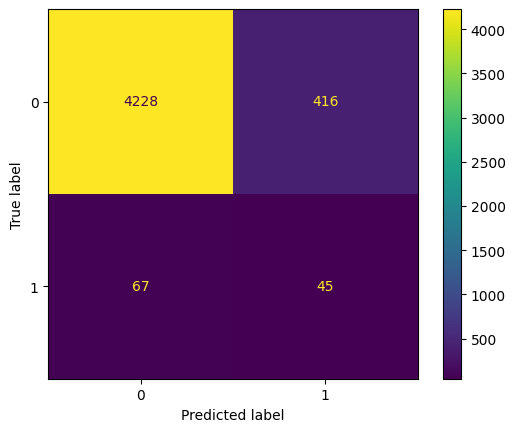

In [15]:
numpy_arrays = [t.cpu().numpy() for t in preds]
preds = np.array(numpy_arrays)

conf_matrix = metrics.confusion_matrix(labels, preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

### F1-score and AUC

In [16]:
f1 = metrics.f1_score(labels, preds)
auc = metrics.roc_auc_score(labels, preds)
print('f1: ', f1)
print('auc: ', auc)

f1:  0.15706806282722513
auc:  0.6561038821213241


### Precision, Recall and Accuracy

In [17]:
precision = metrics.precision_score(labels, preds)
recall = metrics.recall_score(labels, preds)
accuracy = metrics.accuracy_score(labels, preds)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)

precision:  0.09761388286334056
recall:  0.4017857142857143
accuracy:  0.898444070647603


### ROC-curve, FPR and TPR thresholds

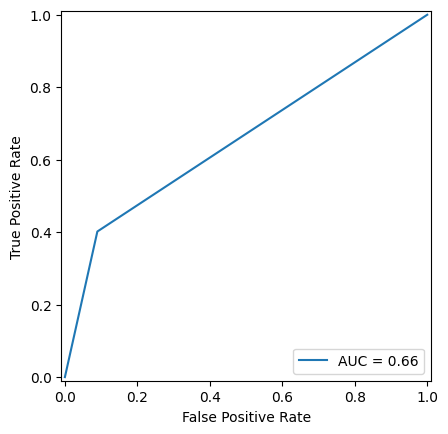

In [18]:
fpr, tpr, thresholds = metrics.roc_curve(labels, preds)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

display.plot()